# 2
* 오늘 할 일
- edit distance 기준으로 positive dataset 뽑기
- 좀 넓게 잡고, semantic similarity 기준으로도 추가
- 오늘은 xgboost + extra feature 기준으로 최대한 올려볼 것!

---
## Edit Distance 기준으로 positive dataset 뽑아보기

In [13]:
import numpy as np
from collections import Counter
import editdistance
import seaborn as sns

In [5]:
import sys
sys.path.append("/home/angrypark/paraphrase_detection/code/")

from utils.utils import JamoProcessor

In [6]:
processor = JamoProcessor()

기존에는 대충 editdistance가 어느정도였나?

In [53]:
positives = list()
negatives = list()
lengths = list()
with open("../data/small/train.txt", "r") as f:
    for line in f:
        splited = line.strip().split("\t")
        a = processor.word_to_jamo(splited[0]).replace("_", "")
        b = processor.word_to_jamo(splited[1]).replace("_", "")
        if splited[2] == "1":
            positives.append(editdistance.eval(a, b))
            lengths.append(len(splited[0]))
        else:
            negatives.append(editdistance.eval(a, b))

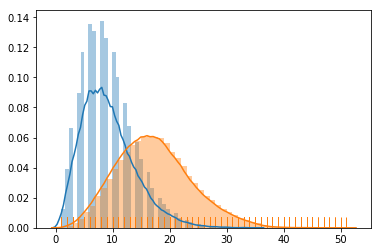

In [19]:
sns.distplot(positives, rug=True)
sns.distplot(negatives, rug=True)

In [20]:
normalized_positives = list()
normalized_negatives = list()
with open("../data/small/train.txt", "r") as f:
    for line in f:
        splited = line.strip().split("\t")
        a = processor.word_to_jamo(splited[0]).replace("_", "")
        b = processor.word_to_jamo(splited[1]).replace("_", "")
        if splited[2] == "1":
            normalized_positives.append(editdistance.eval(a, b)/max([len(a), len(b)]))
        else:
            normalized_negatives.append(editdistance.eval(a, b)/max([len(a), len(b)]))

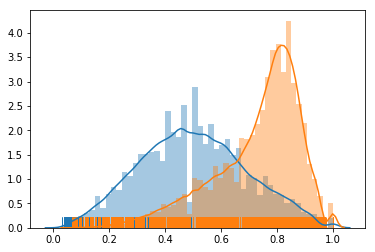

In [21]:
sns.distplot(normalized_positives, rug=True)
sns.distplot(normalized_negatives, rug=True)

In [25]:
with open("../data/test_queries.txt", "r") as f:
    q = [line.strip().split("\t")[1] for line in f]

- 자모간 editdistance / max_length가 0.7 이하
- 문장의 길이가 20자 이하
- token이 10개 이하

In [29]:
from text.tokenizers import SentencePieceTokenizer

In [33]:
class Config:
    def __init__(self):
        self.sent_piece_model = "/media/scatter/scatterdisk/tokenizer/sent_piece.100K.model"
config = Config()
tokenizer = SentencePieceTokenizer(config)

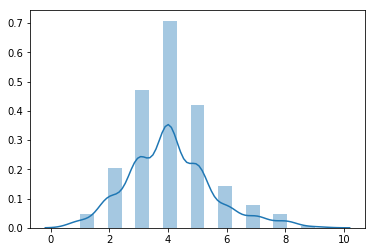

In [35]:
sns.distplot([len(tokenizer.tokenize(line)) for line in q])

In [37]:
from itertools import islice

In [55]:
from difflib import SequenceMatcher

string1 = "apple pie available"
string2 = "come have some apple pies"

match = SequenceMatcher(None, string1, string2).find_longest_match(0, len(string1), 0, len(string2))

print(match)  # -> Match(a=0, b=15, size=9)
print(string1[match.a: match.a + match.size])  # -> apple pie
print(string2[match.b: match.b + match.size])  # -> apple pie

Match(a=0, b=15, size=9)
apple pie
apple pie


In [57]:
positives = list()
negatives = list()
lengths = list()
with open("../data/small/train.txt", "r") as f:
    for line in f:
        splited = line.strip().split("\t")
        a_jamos = processor.word_to_jamo(splited[0]).replace("_", "")
        b_jamos = processor.word_to_jamo(splited[1]).replace("_", "")
        match = SequenceMatcher(None, a_jamos, b_jamos).find_longest_match(0, len(a_jamos), 0, len(b_jamos))
        long_length = max([len(a_jamos), len(b_jamos)])
        small_length = min([len(a_jamos), len(b_jamos)])
        if splited[2] == "1":
            positives.append([match.size, small_length, long_length])
        else:
            negatives.append([match.size, small_length, long_length])

### substring 길이 구분

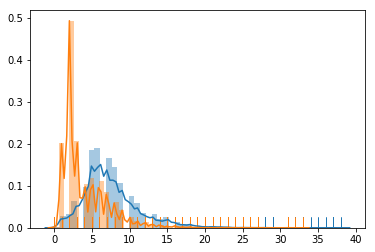

In [61]:
sns.distplot([p[0] for p in positives], rug=True)
sns.distplot([p[0] for p in negatives], rug=True)

### substring / small_length

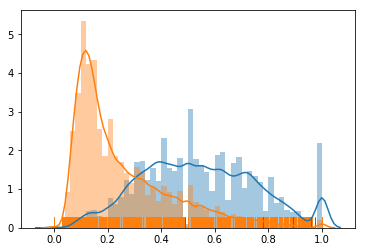

In [62]:
sns.distplot([p[0]/p[1] for p in positives], rug=True)
sns.distplot([p[0]/p[1] for p in negatives], rug=True)

### substring / max_length

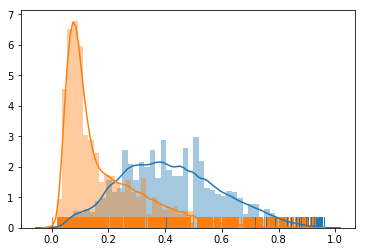

In [63]:
sns.distplot([p[0]/p[2] for p in positives], rug=True)
sns.distplot([p[0]/p[2] for p in negatives], rug=True)

In [66]:
def similar_score(a, b):
    if a==b:
        return 0
    
    def proper_edit_distance(a_jamos, b_jamos):
        long_length = max([len(a_jamos), len(b_jamos)])
        edit_distance = editdistance.eval(a_jamos, b_jamos) / long_length
        return 1 - edit_distance
    
    def substring(a_jamos, b_jamos):
        long_length = max([len(a_jamos), len(b_jamos)])
        match = SequenceMatcher(None, a_jamos, b_jamos).find_longest_match(0, len(a_jamos), 0, len(b_jamos))
        return match.size / long_length
    
    a_jamos = processor.word_to_jamo(a).replace("_", "")
    b_jamos = processor.word_to_jamo(b).replace("_", "")
    
    if not_same(a, b) & proper_edit_distance(a_jamos, b_jamos) & substring(a_jamos, b_jamos):
        return True
    else: return False

In [67]:
%%time
BATCH_SIZE = 20000
BASE_DIR = "/media/scatter/scatterdisk/reply_matching_model/sorted_normalized/sol.raw_{}.txt"
TARGET_DIR = "/media/scatter/scatterdisk/paraphrase_detection/sol.normalized/sol.raw_{}.txt"
with open(BASE_DIR.format(2), "r") as f1, open(TARGET_DIR.format(2), "w") as f2:
    for _ in range(1):
    #while True:
        lines = list(islice(f1, BATCH_SIZE))
        if not lines:
            break
        else:
            queries = [line.strip() for line in lines]
            length = len(queries)
            for i in range(length):
                a = queries[i]
                for j in range(i+1, length):
                    b = queries[j]
                    if proper_pair(a, b):
                        f2.write(a + "\t" + b + "\n")

KeyboardInterrupt: 